(papr)=
# Peak-to-average power

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sdr

%config InlineBackend.print_figure_kwargs = {"facecolor" : "w"}
# %matplotlib widget

## QPSK signal with various pulse shapes

In [2]:
qpsk = sdr.PSK(4, phase_offset=45)
N_symbols = 1_000
s = np.random.randint(0, qpsk.order, N_symbols)
x = qpsk.modulate(s)

In [3]:
span = 8  # Length of the pulse shape in symbols
sps = 20  # Samples per symbol

In [4]:
def pulse_shape(alpha):
    if alpha is None:
        h = np.zeros(span * sps + 1)
        h[span * sps // 2 - sps // 2 : span * sps // 2 + sps // 2] = 1 / np.sqrt(sps)
    else:
        h = sdr.root_raised_cosine(alpha, span, sps)
    fir = sdr.Interpolator(sps, h)

    bb = fir(x)
    pb = sdr.to_real_pb(bb)

    return bb, sdr.papr(bb), pb, sdr.papr(pb)

In [5]:
x_bb_rect, papr_bb_rect, x_pb_rect, papr_pb_rect = pulse_shape(None)
x_bb_0p1, papr_bb_0p1, x_pb_0p1, papr_pb_0p1 = pulse_shape(0.1)
x_bb_0p5, papr_bb_0p5, x_pb_0p5, papr_pb_0p5 = pulse_shape(0.5)
x_bb_0p9, papr_bb_0p9, x_pb_0p9, papr_pb_0p9 = pulse_shape(0.9)

## Examine time domain

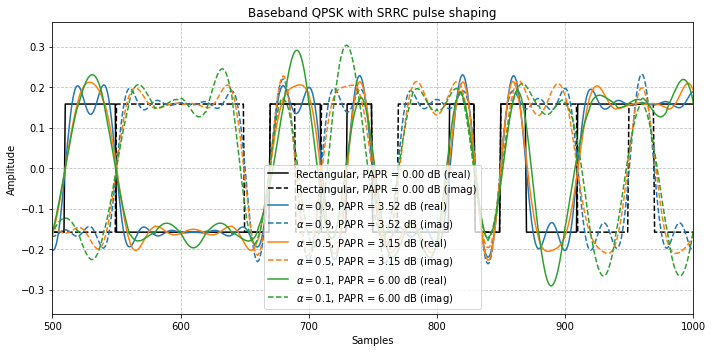

In [6]:
plt.figure(figsize=(10, 5))
sdr.plot.time_domain(x_bb_rect, color="k", label=f"Rectangular, PAPR = {papr_bb_rect:.2f} dB", diff="line")
sdr.plot.time_domain(x_bb_0p9, label=rf"$\alpha = 0.9$, PAPR = {papr_bb_0p9:.2f} dB", diff="line")
sdr.plot.time_domain(x_bb_0p5, label=rf"$\alpha = 0.5$, PAPR = {papr_bb_0p5:.2f} dB", diff="line")
sdr.plot.time_domain(x_bb_0p1, label=rf"$\alpha = 0.1$, PAPR = {papr_bb_0p1:.2f} dB", diff="line")
plt.xlim(25 * sps, 50 * sps)
plt.legend()
plt.title("Baseband QPSK with SRRC pulse shaping")
plt.tight_layout()
plt.show()

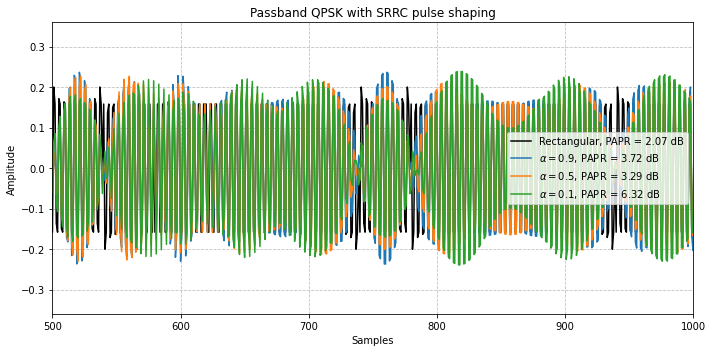

In [7]:
plt.figure(figsize=(10, 5))
sdr.plot.time_domain(x_pb_rect, color="k", label=f"Rectangular, PAPR = {papr_pb_rect:.2f} dB")
sdr.plot.time_domain(x_pb_0p9, label=rf"$\alpha = 0.9$, PAPR = {papr_pb_0p9:.2f} dB")
sdr.plot.time_domain(x_pb_0p5, label=rf"$\alpha = 0.5$, PAPR = {papr_pb_0p5:.2f} dB")
sdr.plot.time_domain(x_pb_0p1, label=rf"$\alpha = 0.1$, PAPR = {papr_pb_0p1:.2f} dB")
plt.xlim(25 * sps, 50 * sps)
plt.legend()
plt.title("Passband QPSK with SRRC pulse shaping")
plt.tight_layout()
plt.show()

## Examine frequency domain

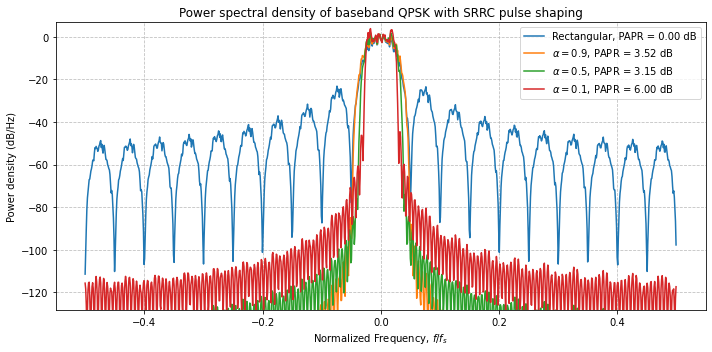

In [8]:
plt.figure(figsize=(10, 5))
sdr.plot.periodogram(x_bb_rect, length=1024, overlap=1024 - 256, label=f"Rectangular, PAPR = {papr_bb_rect:.2f} dB")
sdr.plot.periodogram(x_bb_0p9, length=1024, overlap=1024 - 256, label=rf"$\alpha = 0.9$, PAPR = {papr_bb_0p9:.2f} dB")
sdr.plot.periodogram(x_bb_0p5, length=1024, overlap=1024 - 256, label=rf"$\alpha = 0.5$, PAPR = {papr_bb_0p5:.2f} dB")
sdr.plot.periodogram(x_bb_0p1, length=1024, overlap=1024 - 256, label=rf"$\alpha = 0.1$, PAPR = {papr_bb_0p1:.2f} dB")
plt.title("Power spectral density of baseband QPSK with SRRC pulse shaping")
plt.show()

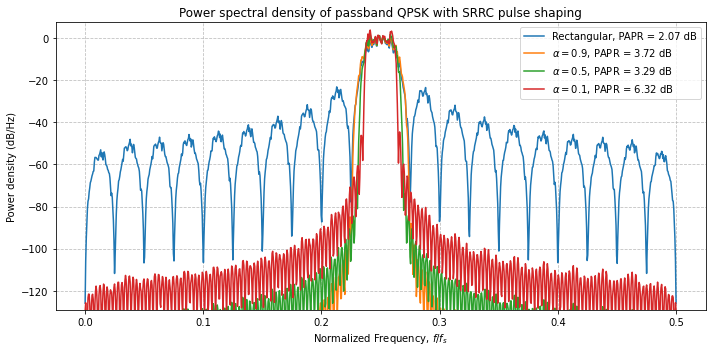

In [9]:
plt.figure(figsize=(10, 5))
sdr.plot.periodogram(
    x_pb_rect,
    length=2048,
    overlap=2048 - 512,
    x_axis="one-sided",
    label=f"Rectangular, PAPR = {papr_pb_rect:.2f} dB",
)
sdr.plot.periodogram(
    x_pb_0p9,
    length=2048,
    overlap=2048 - 512,
    x_axis="one-sided",
    label=rf"$\alpha = 0.9$, PAPR = {papr_pb_0p9:.2f} dB",
)
sdr.plot.periodogram(
    x_pb_0p5,
    length=2048,
    overlap=2048 - 512,
    x_axis="one-sided",
    label=rf"$\alpha = 0.5$, PAPR = {papr_pb_0p5:.2f} dB",
)
sdr.plot.periodogram(
    x_pb_0p1,
    length=2048,
    overlap=2048 - 512,
    x_axis="one-sided",
    label=rf"$\alpha = 0.1$, PAPR = {papr_pb_0p1:.2f} dB",
)
plt.title("Power spectral density of passband QPSK with SRRC pulse shaping")
plt.show()

## Plot across excess bandwidth

In [10]:
def sweep_alpha(order):
    bpsk = sdr.PSK(order)
    N_symbols = 1_000
    s = np.random.randint(0, bpsk.order, N_symbols)
    x = bpsk.modulate(s)

    alphas = np.linspace(0, 1, 20)
    bb_papr = []
    pb_papr = []

    for alpha in alphas:
        h = sdr.root_raised_cosine(alpha, span, sps)
        fir = sdr.Interpolator(sps, h)

        bb = fir(x)
        pb = sdr.to_real_pb(bb)

        bb_papr.append(sdr.papr(bb))
        pb_papr.append(sdr.papr(pb))

    return alphas, bb_papr, pb_papr

In [11]:
alpha, bpsk_bb_papr, bpsk_pb_papr = sweep_alpha(2)
alpha, qpsk_bb_papr, qpsk_pb_papr = sweep_alpha(4)
alpha, psk8_bb_papr, psk8_pb_papr = sweep_alpha(8)
alpha, psk16_bb_papr, psk16_pb_papr = sweep_alpha(16)

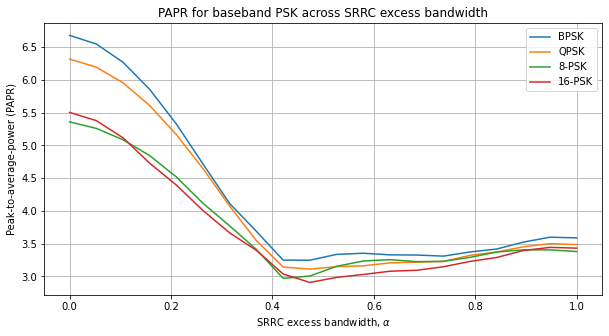

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(alpha, bpsk_bb_papr, label="BPSK")
plt.plot(alpha, qpsk_bb_papr, label="QPSK")
plt.plot(alpha, psk8_bb_papr, label="8-PSK")
plt.plot(alpha, psk16_bb_papr, label="16-PSK")
plt.grid(True)
plt.legend()
plt.xlabel(r"SRRC excess bandwidth, $\alpha$")
plt.ylabel("Peak-to-average-power (PAPR)")
plt.title("PAPR for baseband PSK across SRRC excess bandwidth")
plt.show()

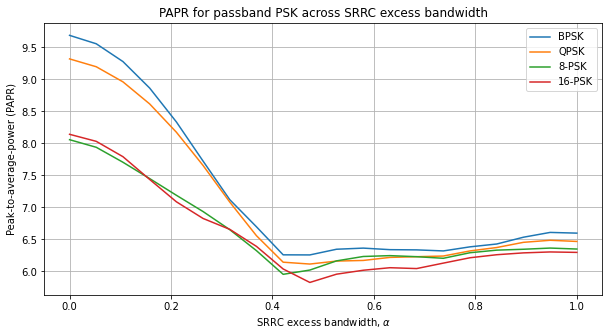

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(alpha, bpsk_pb_papr, label="BPSK")
plt.plot(alpha, qpsk_pb_papr, label="QPSK")
plt.plot(alpha, psk8_pb_papr, label="8-PSK")
plt.plot(alpha, psk16_pb_papr, label="16-PSK")
plt.grid(True)
plt.legend()
plt.xlabel(r"SRRC excess bandwidth, $\alpha$")
plt.ylabel("Peak-to-average-power (PAPR)")
plt.title("PAPR for passband PSK across SRRC excess bandwidth")
plt.show()